# ML Model Development - Python OS library

We start by loading the environment parameters from the configuration file

In [2]:
import yaml
import getpass
import os

# Load the yaml file
os.chdir("/home/jovyan/work/development")
stream = open('viya_config.yml', 'r')
settings = yaml.load(stream, yaml.SafeLoader)

# connection parameters
hostname = settings['hostname']
port = settings['port']
username = settings['username']
password = getpass.getpass()

 ········


## Connect to SAS Viya

To get started connect to your environment

> **Note:**  We use swat - SAS Scripting Wrapper for Analytics Transfer - available via *pip install swat*

In [3]:
import swat

# Connect to CAS server
s = swat.CAS(hostname, port, username, password)

## Access Data - CAS

In [4]:
table_name = 'hmeq_id'

# Define default caslib
s.sessionprop.setsessopt(caslib='Public')

# load table in memory
s.table.loadTable(path=str(table_name).upper()+".sashdat", casout={"name":table_name, "replace":True})

# CASTable view
castbl = s.CASTable(table_name)

NOTE: 'Public' is now the active caslib.
NOTE: Cloud Analytic Services made the file HMEQ_ID.sashdat available as table HMEQ_ID in caslib Public.


In [6]:
type(castbl)

swat.cas.table.CASTable

In [5]:
castbl.head()

,Unique_ID,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,_PARTIND_
0,101.0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN,0.0
1,201.0,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN,1.0
2,301.0,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN,1.0
3,401.0,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,501.0,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN,0.0


# Local data analysis

In [8]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics  import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Convert the table to a local Dataframe

In [9]:
# Bring data locally
df = castbl.to_frame()

In [10]:
type(df)

swat.dataframe.SASDataFrame

`SASDataFrame` is a subclass of `pandas.DataFrame`. Therefore, anything you can do with a `pandas.DataFrame` will also work with `SASDataFrame`. The only difference is that `SASDataFrame` objects contain extra metadata familiar to SAS users.

## Data Exploration and Preparation - Local

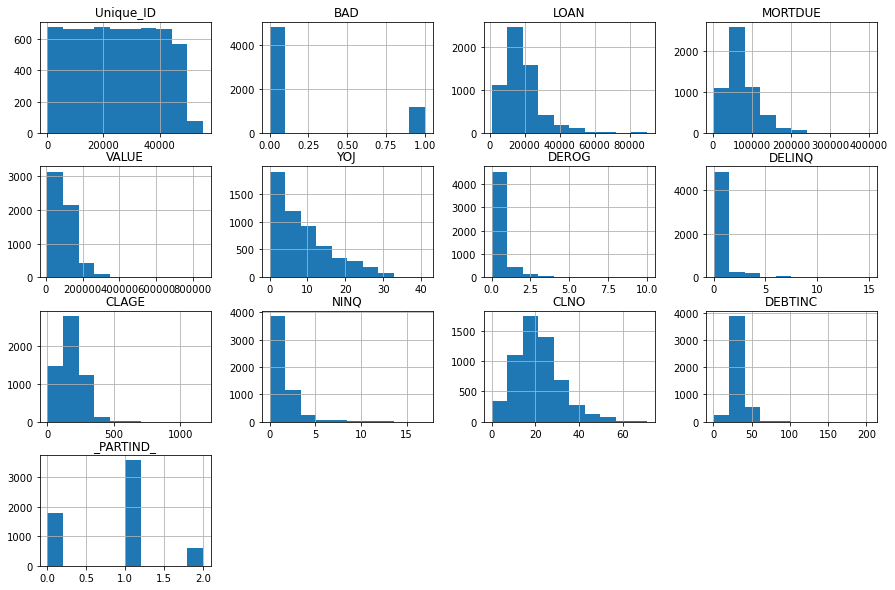

In [11]:
hists = df.hist(figsize = (15, 10))

### set variable shortcuts

In [18]:
# Define target variable
target = 'BAD'

# get categorical/numerical variables
input_vars = df.drop([target,'Unique_ID','_PARTIND_'],axis=1).columns.values
kinds = np.array([dt.kind for dt in df.drop([target,'Unique_ID','_PARTIND_'],axis=1).dtypes])

# Variable lists
categorical_vars = list(input_vars[kinds == 'O'])
numerical_vars = list(input_vars[kinds != 'O'])
all_vars = categorical_vars + numerical_vars + [target]

### Prepare data for model

In [21]:
# Split into training and validation / target and inputs
X_train = df[df['_PARTIND_'] == 1].drop([target,'Unique_ID','_PARTIND_'], axis = 1)
X_valid = df[df['_PARTIND_'] == 0].drop([target,'Unique_ID','_PARTIND_'], axis = 1)
y_train = df[df['_PARTIND_'] == 1][target]
y_valid = df[df['_PARTIND_'] == 0][target]

## Build model - Scikit-learn

In [22]:
# Define data pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_vars),
    ('cat', categorical_transformer, categorical_vars)])

ml_pipe = Pipeline(steps=[
('preprocessor', preprocessor),
('model', GradientBoostingClassifier(random_state=3))])

fit = ml_pipe.fit(X_train, y_train)

### Assess model

In [23]:
# put results in pandas dataframe
results_df = pd.DataFrame(dict(actual = y_valid, pred = ml_pipe.predict_proba(X_valid)[:,1]))

# Predict and assess model
gb_y_score           = ml_pipe.predict(X_valid)
gb_misclassification = 1 - accuracy_score(y_valid, gb_y_score)
gb_confusion_matrix  = confusion_matrix(y_valid, gb_y_score)

# Add Python model results to CAS to assess
pytbl = s.upload_frame(results_df, casout=dict(name='GBT_sklearn_predictions', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table GBT_SKLEARN_PREDICTIONS in caslib Public.
NOTE: The table GBT_SKLEARN_PREDICTIONS has been created in caslib Public from binary data uploaded to Cloud Analytic Services.


In [24]:
gb_misclassification

0.10067114093959728

# Register Model

In [25]:
# SAS Model Manager Project Name
PROJECT_NAME = "ModelOps SCH"

## Add model to repository - sklearn

In [26]:
import sasctl.pzmm as pzmm
from utils.mm_utils import *

# model
MODEL = ml_pipe
MODEL_PREFIX = 'Sklearn_GBT'

### Initialize folder & save pickle

In [27]:
# create model folder
MODEL_FOLDER = init_folder(MODEL_PREFIX)
pzmm.PickleModel.pickleTrainedModel(None, MODEL, MODEL_PREFIX, MODEL_FOLDER)

Model Sklearn_GBT was successfully pickled and saved to /home/jovyan/work/development/models/Sklearn_GBT/Sklearn_GBT.pickle.


### Write requirement.txt

In [28]:
# write_requirements(MODEL_FOLDER, 'requirements.txt')

In [29]:
%%writefile $MODEL_FOLDER/requirements.txt
scikit-learn==1.0.2
pandas==1.4.0

Overwriting /home/jovyan/work/development/models/Sklearn_GBT/requirements.txt


### Write inference script

In [30]:
# threshold for prediction
threshold = 0.5
# Get list of variables
vars_string = str(input_vars).replace(" ", ", ")
print(vars_string)
remove_characters = ["'", "[", "]"]
for character in remove_characters:
    vars_string = vars_string.replace(character, "")

['LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE'
, 'NINQ', 'CLNO', 'DEBTINC']


In [31]:
scoringstring = '''
import pickle
import pandas as pd
                            
global _thisModelFit
        
with open('{0}', 'rb') as _pFile:
    _thisModelFit = pickle.load(_pFile)

def scoreSklearn_GBT({1}):
    "Output: EM_EVENTPROBABILITY, EM_CLASSIFICATION"
    
    try:
        _thisModelFit
    except NameError:

        with open('{0}', 'rb') as _pFile:
            _thisModelFit = pickle.load(_pFile)
    
    inputArray = pd.DataFrame([[{1}]], columns = {2})
    
    prediction = _thisModelFit.predict_proba(inputArray)

    EM_EVENTPROBABILITY = float(prediction[:,1])

    if (EM_EVENTPROBABILITY >= {3}):
        EM_CLASSIFICATION = '1'
    else:
        EM_CLASSIFICATION = '0'

    return(EM_EVENTPROBABILITY, EM_CLASSIFICATION)
'''.format(MODEL_PREFIX + '.pickle',vars_string, str(input_vars).replace(" ", ", "),str(threshold))

In [32]:
text_file = open(MODEL_FOLDER + '/' + MODEL_PREFIX + 'Score.py', "w")
n = text_file.write(scoringstring)
text_file.close()

### Write Metadata files

In [33]:
# init JSONFiles object for metadata files
JSONFiles = pzmm.JSONFiles()

#### input variables

In [34]:
#write input.json
JSONFiles.writeVarJSON(df[input_vars], isInput=True, jPath=MODEL_FOLDER)

/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputJSON = outputJSON.append([outputRow], ignore_index=True)
/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputJSON = outputJSON.append([outputRow], ignore_index=True)
/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputJSON = outputJSON.append([outputRow], ignore_index=True)
/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

inputVar.json was successfully written and saved to /home/jovyan/work/development/models/Sklearn_GBT/inputVar.json


/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputJSON = outputJSON.append([outputRow], ignore_index=True)
/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputJSON = outputJSON.append([outputRow], ignore_index=True)
/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputJSON = outputJSON.append([outputRow], ignore_index=True)
/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

#### output variables

In [35]:
NAMES=['P_BAD0', 'P_BAD1', 'EM_CLASSIFICATION', 'EM_EVENTPROBABILITY']
LABELS=['0', '1']
EVENTPROB = 0.5

outputVar = get_output_variables(NAMES, LABELS, EVENTPROB)
#write output.json
JSONFiles.writeVarJSON(outputVar, isInput=False, jPath=MODEL_FOLDER)

outputVar.json was successfully written and saved to /home/jovyan/work/development/models/Sklearn_GBT/outputVar.json


/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputJSON = outputJSON.append([outputRow], ignore_index=True)
/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputJSON = outputJSON.append([outputRow], ignore_index=True)
/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputJSON = outputJSON.append([outputRow], ignore_index=True)
/opt/conda/lib/python3.9/site-packages/sasctl/pzmm/writeJSONFiles.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

#### model properties

In [36]:
TARGET_VALUE = "1"

In [37]:
JSONFiles.writeModelPropertiesJSON(modelName=MODEL_PREFIX,
                                   modelDesc='Sklearn classifier',
                                   targetVariable=target,
                                   modelType='Pipeline Gradient Boosting',
                                   modelPredictors=input_vars,
                                   targetEvent=TARGET_VALUE,
                                   numTargetCategories=2,
                                   eventProbVar='EM_EVENTPROBABILITY',
                                   jPath=MODEL_FOLDER,
                                   modeler=username)

ModelProperties.json was successfully written and saved to /home/jovyan/work/development/models/Sklearn_GBT/ModelProperties.json


In [38]:
# fileMetatdata file
JSONFiles.writeFileMetadataJSON(MODEL_PREFIX, jPath=MODEL_FOLDER)

fileMetaData.json was successfully written and saved to /home/jovyan/work/development/models/Sklearn_GBT/fileMetaData.json


#### evaluation data

In [39]:
# Evaluate model (train, validation)
train_fit_df = pd.DataFrame(dict(actual = y_train, pred = ml_pipe.predict_proba(X_train)[:,1]))
results_df = pd.DataFrame(dict(actual = y_valid, pred = ml_pipe.predict_proba(X_valid)[:,1]))

# fit statistics
JSONFiles.calculateFitStat(
    validateData=[np.array(y_valid.astype(int)), np.array(results_df['pred'])],
    trainData=[np.array(y_train.astype(int)), np.array(train_fit_df["pred"])],
    testData=None,
    jPath=MODEL_FOLDER)

# ROCLiftStat
JSONFiles.generateROCLiftStat(
    targetName=target,
    targetValue=TARGET_VALUE,
    swatConn=s,
    validateData=pd.DataFrame({'col1': y_valid.astype(int),'col2': results_df['pred']}),
    trainData=pd.DataFrame({'col1': y_train.astype(int), 'col2': train_fit_df["pred"]}),
    testData=None,
    jPath=MODEL_FOLDER)

dmcas_fitstat.json was successfully written and saved to /home/jovyan/work/development/models/Sklearn_GBT/dmcas_fitstat.json
NOTE: Added action set 'percentile'.
NOTE: Cloud Analytic Services made the uploaded file available as table SCOREDVALUES in caslib Public.
NOTE: The table SCOREDVALUES has been created in caslib Public from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table SCOREDVALUES in caslib Public.
NOTE: The table SCOREDVALUES has been created in caslib Public from binary data uploaded to Cloud Analytic Services.
dmcas_roc.json was successfully written and saved to /home/jovyan/work/development/models/Sklearn_GBT/dmcas_roc.json
dmcas_lift.json was successfully written and saved to /home/jovyan/work/development/models/Sklearn_GBT/dmcas_lift.json


#### compress model folder

In [40]:
#Zip folder
pzmm.ZipModel.zipFiles(MODEL_FOLDER,MODEL_PREFIX)

### Import Model

In [59]:
zPath = MODEL_FOLDER + "/" + MODEL_PREFIX + '.zip'

with Session("https://"+hostname, username, password, verify_ssl=False):
    zipfile = open(zPath, 'rb')
    model_repository.import_model_from_zip(MODEL_PREFIX,
                                           PROJECT_NAME,
                                           file=zipfile,
                                           version='latest')
    zipfile.close()

/opt/conda/lib/python3.9/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.96.1.158'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [107]:
#!mkdir -p /opt/sas/viya/config/data/modelsvr/resources/38801ef9-cca2-43c6-940a-498379aada53
joblib.dump(ml_pipe, '/opt/sas/viya/config/data/modelsvr/resources/38801ef9-cca2-43c6-940a-498379aada53/ml_pipe.pickle')

['/opt/sas/viya/config/data/modelsvr/resources/38801ef9-cca2-43c6-940a-498379aada53/ml_pipe.pickle']